<a href="https://colab.research.google.com/github/iqbalsublime/AE_LFW_FaceImageReconstruction/blob/main/AE_LFW_Noise_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

In [3]:
# download dataset
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2021-07-13 12:22:20--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  35.1MB/s    in 5.4s    

2021-07-13 12:22:25 (32.0 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [4]:
# extract dataset
! tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [5]:
#capture paths to images
face_images = glob.glob('lfw/**/*.jpg')

In [6]:
all_images = []

for i in tqdm(face_images):
  img = image.load_img(i, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  all_images.append(img)

100%|██████████| 13233/13233 [00:14<00:00, 887.34it/s]


In [7]:
all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

In [8]:
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

In [9]:
# get low resolution images for the training set
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [10]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 80, 80, 64)        0     

In [12]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

a_e = autoencoder.fit(train_x_px, train_x,
            epochs=50,
            batch_size=256,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

Epoch 1/50
47/47 [==============================] - 131s 2s/step - loss: 0.0481 - val_loss: 0.0137
Epoch 2/50
47/47 [==============================] - 69s 1s/step - loss: 0.0083 - val_loss: 0.0053
Epoch 3/50
47/47 [==============================] - 70s 2s/step - loss: 0.0046 - val_loss: 0.0045
Epoch 4/50
47/47 [==============================] - 71s 2s/step - loss: 0.0040 - val_loss: 0.0035
Epoch 5/50
47/47 [==============================] - 71s 2s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/50
47/47 [==============================] - 71s 2s/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/50
47/47 [==============================] - 71s 2s/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/50
47/47 [==============================] - 71s 2s/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/50
47/47 [==============================] - 71s 2s/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/50
47/47 [==============================] - 71s 2s/step - loss: 0.0028 - val_loss: 0.0029
Epoch 11/50
47/47 

In [13]:
predictions = autoencoder.predict(val_x_px)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


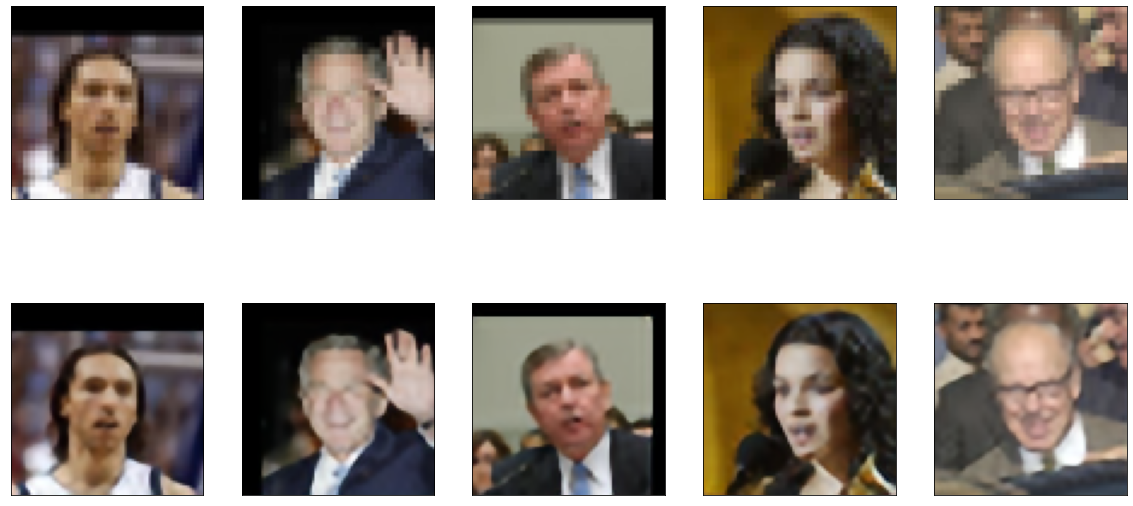

In [14]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()